In [4]:
%reload_ext autoreload
%autoreload 2

In [8]:
!pip install openpyxl -qq
!pip install tenacity -qq
!pip install loguru -qq
!pip install git+https://git@github.com/NASA-IMPACT/evalem.git@develop -qq
!pip install rake-nltk -qq

In [9]:
import json
from typing import List

In [10]:
from pprint import pprint
from IPython.display import display, HTML

In [11]:
from loguru import logger
import glob
import random
import re

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load Validation Data

In [13]:
FILE_PATH = "data/OSDR_LLM_QA_correctFormat.xlsx"

In [14]:
def load_data(path) -> pd.DataFrame:
    data = pd.read_excel(path)
    data = data.rename(columns={data.columns[0]: 'context'})
    return data

In [15]:
def simplify_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    transformed_data = []
    for index, row in df.iterrows():
        context = row['context']
        url = row['URL']
        for i in range(1, 6): # Assuming there are 5 question-answer pairs
            question = row[f'Question {i}']
            answer = row[f'Question {i} Answer']
            if question and answer:
                transformed_data.append(dict(
                    context=context,
                    context_hash=abs(hash(context)) % (10 ** 8),
                    url=url,
                    question=question,
                    answer=answer,
                ))
    df =  pd.DataFrame(transformed_data)
    return df.dropna(subset=['question', 'answer'], how='all')

In [16]:
data = load_data(FILE_PATH)
data.head()

,context,URL,Question 1,Question 1 Answer,Question 2,Question 2 Answer,Question 3,Question 3 Answer,Question 4,Question 4 Answer,Question 5,Question 5 Answer
0,Genome-wide transcriptional profiling showed t...,https://sciencediscoveryengine.nasa.gov#/previ...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...,What kind of experiments showed differential r...,simulation experiments on ground testing space...,What is overrepresented in the different exper...,the same GO groups including a large multigene...,what analytical methodology provided integrati...,Self-organizing maps of the Gene Expression Dy...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...
1,The objective of the Rodent Research-5 (RR-5) ...,https://sciencediscoveryengine.nasa.gov#/previ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...,What type of mice and how old were they when f...,a cohort of forty 30-weeks-old female BALB/cAn...,How many days after launch were the mice treat...,Six days after launch,How was the Earth recovery period for the subj...,"Following their return to Earth, the experimen...",What specific type of samples and from which c...,GeneLab received RNA later preserved dorsal sk...
2,The radiation bystander response is an importa...,https://sciencediscoveryengine.nasa.gov#/previ...,What is a key component of the overall respons...,The radiation bystander response,Which methods were used to measure the bystand...,using chromosomal aberration and micronucleus ...,What was shown to increase chromosomal structu...,depletion or mutation of RAD9,what cellular pathways were altered as a resul...,The depletion of RAD9 caused changes in numero...,How were differences in the activation of tran...,The use of network analysis allowed the discov...
3,Martian regolith (unconsolidated surface mater...,https://sciencediscoveryengine.nasa.gov#/previ...,What is considered a potential medium for plan...,Martian regolith (unconsolidated surface mater...,What is the level of hydrated magnesium sulfat...,hydrated magnesium sulfate mineral levels in t...,What was characterized in the study to identif...,The early Arabidopsis root transcriptome respo...,how was the genetic comparison approached to d...,A comparative analysis was conducted between t...,What distinctive characteristic does the cax1-...,The cax1-1 mutant line demonstrated relative t...
4,The objective of the Rodent Research-23 missio...,https://sciencediscoveryengine.nasa.gov#/previ...,What was the objective of the Rodent Research-...,to better understand the effects of spacefligh...,How many mice and of what type were involved i...,"twenty male, C57BL/6J, 16-17 weeks-old mice",How long were the mice in the RR-23 study main...,maintained in microgravity for 38 days,What was the procedure followed for the mice f...,"The mice, after landing in the Atlantic, were ...",How was RNA extraction and analysis managed fo...,Adrenal glands of the mice were preserved by i...


## Data Peek

Here we pick a sample row to inspect the nature of data.
- What each column looks like

In [17]:
def peek_data(data: pd.DataFrame, row_index: int = 0):
    print(f"Row = {row_index}")
    row = data.iloc[row_index]
    for col, value in zip(data.columns, row):
        display(HTML(f"<h4>{col}</h4>"))
        print(value)
        display(HTML("<hr/>"))

In [18]:
data.shape

(60, 12)

In [19]:
# index = random.randint(0, len(data))
peek_data(data, row_index=0)

Row = 0


Genome-wide transcriptional profiling showed that reducing gravity levels in the International Space Station (ISS) causes important alterations in Drosophila gene expression intimately linked to imposed spaceflight-related environmental constrains during Drosophila metamorphosis. However, simulation experiments on ground testing space-related environmental constraints, show differential responses. Curiously, although particular genes are not common in the different experiments, the same GO groups including a large multigene family related with behavior, stress response and organogenesis are over represented in them. A global and integrative analysis using the gene expression dynamics inspector (GEDI) self-organizing maps, reveals different degrees in the responses of the transcriptome when using different environmental conditions or microgravity/hypergravity simulation devices. These results suggest that the transcriptome is finely tuned to normal gravity. In regular environmental cond

https://sciencediscoveryengine.nasa.gov#/preview?id=%2FSDE%2Fgenelab_lsda%2F%7Chttps:%2F%2Fosdr.nasa.gov%2Fbio%2Frepo%2Fdata%2Fstudies%2FOSD-70%2F&query=%7B%22name%22:%22query-smd-primary%22,%22scope%22:%22All%22,%22text%22:%22osd-70%22%7D


Where were the gene expression alterations in Drosophila observed during their metamorphosis?


reducing gravity levels in the International Space Station (ISS)


What kind of experiments showed differential responses in gene expression?


simulation experiments on ground testing space-related environmental constraints


What is overrepresented in the different experiments despite particular genes not being common?


the same GO groups including a large multigene family related with behavior, stress response and organogenesis


what analytical methodology provided integrative insights on transcriptome variations?


Self-organizing maps of the Gene Expression Dynamics Inspector (GEDI) were utilized to reveal transcriptome variations under various environmental conditions or microgravity/hypergravity simulation devices.


What are the implications of the findings in terms of the tuning of the transcriptome to Earth's gravity and its variations in extreme environmental conditions?


The findings indicate that the finely adjusted transcriptome is tuned to normal Earth gravity, showing a more marked and coherent genetic response when environmental conditions significantly deviate from optimal.


## Simplify Data

Here we separate out individual question/answer pair into separate row for each context.


This is used for simplifying the validation process so that each row would have consistent view of data.

In [20]:
data = simplify_columns(data)
data.head(10)

,context,context_hash,url,question,answer
0,Genome-wide transcriptional profiling showed t...,18195912,https://sciencediscoveryengine.nasa.gov#/previ...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...
1,Genome-wide transcriptional profiling showed t...,18195912,https://sciencediscoveryengine.nasa.gov#/previ...,What kind of experiments showed differential r...,simulation experiments on ground testing space...
2,Genome-wide transcriptional profiling showed t...,18195912,https://sciencediscoveryengine.nasa.gov#/previ...,What is overrepresented in the different exper...,the same GO groups including a large multigene...
3,Genome-wide transcriptional profiling showed t...,18195912,https://sciencediscoveryengine.nasa.gov#/previ...,what analytical methodology provided integrati...,Self-organizing maps of the Gene Expression Dy...
4,Genome-wide transcriptional profiling showed t...,18195912,https://sciencediscoveryengine.nasa.gov#/previ...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...
5,The objective of the Rodent Research-5 (RR-5) ...,46248971,https://sciencediscoveryengine.nasa.gov#/previ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...
6,The objective of the Rodent Research-5 (RR-5) ...,46248971,https://sciencediscoveryengine.nasa.gov#/previ...,What type of mice and how old were they when f...,a cohort of forty 30-weeks-old female BALB/cAn...
7,The objective of the Rodent Research-5 (RR-5) ...,46248971,https://sciencediscoveryengine.nasa.gov#/previ...,How many days after launch were the mice treat...,Six days after launch
8,The objective of the Rodent Research-5 (RR-5) ...,46248971,https://sciencediscoveryengine.nasa.gov#/previ...,How was the Earth recovery period for the subj...,"Following their return to Earth, the experimen..."
9,The objective of the Rodent Research-5 (RR-5) ...,46248971,https://sciencediscoveryengine.nasa.gov#/previ...,What specific type of samples and from which c...,GeneLab received RNA later preserved dorsal sk...


In [21]:
data.shape

(295, 5)

In [22]:
peek_data(data, row_index=0)

Row = 0


Genome-wide transcriptional profiling showed that reducing gravity levels in the International Space Station (ISS) causes important alterations in Drosophila gene expression intimately linked to imposed spaceflight-related environmental constrains during Drosophila metamorphosis. However, simulation experiments on ground testing space-related environmental constraints, show differential responses. Curiously, although particular genes are not common in the different experiments, the same GO groups including a large multigene family related with behavior, stress response and organogenesis are over represented in them. A global and integrative analysis using the gene expression dynamics inspector (GEDI) self-organizing maps, reveals different degrees in the responses of the transcriptome when using different environmental conditions or microgravity/hypergravity simulation devices. These results suggest that the transcriptome is finely tuned to normal gravity. In regular environmental cond

18195912


https://sciencediscoveryengine.nasa.gov#/preview?id=%2FSDE%2Fgenelab_lsda%2F%7Chttps:%2F%2Fosdr.nasa.gov%2Fbio%2Frepo%2Fdata%2Fstudies%2FOSD-70%2F&query=%7B%22name%22:%22query-smd-primary%22,%22scope%22:%22All%22,%22text%22:%22osd-70%22%7D


Where were the gene expression alterations in Drosophila observed during their metamorphosis?


reducing gravity levels in the International Space Station (ISS)


In [23]:
peek_data(data, row_index=1)

Row = 1


Genome-wide transcriptional profiling showed that reducing gravity levels in the International Space Station (ISS) causes important alterations in Drosophila gene expression intimately linked to imposed spaceflight-related environmental constrains during Drosophila metamorphosis. However, simulation experiments on ground testing space-related environmental constraints, show differential responses. Curiously, although particular genes are not common in the different experiments, the same GO groups including a large multigene family related with behavior, stress response and organogenesis are over represented in them. A global and integrative analysis using the gene expression dynamics inspector (GEDI) self-organizing maps, reveals different degrees in the responses of the transcriptome when using different environmental conditions or microgravity/hypergravity simulation devices. These results suggest that the transcriptome is finely tuned to normal gravity. In regular environmental cond

18195912


https://sciencediscoveryengine.nasa.gov#/preview?id=%2FSDE%2Fgenelab_lsda%2F%7Chttps:%2F%2Fosdr.nasa.gov%2Fbio%2Frepo%2Fdata%2Fstudies%2FOSD-70%2F&query=%7B%22name%22:%22query-smd-primary%22,%22scope%22:%22All%22,%22text%22:%22osd-70%22%7D


What kind of experiments showed differential responses in gene expression?


simulation experiments on ground testing space-related environmental constraints


# promptlab 


**promptlab** provides a programmatic approach to interact with the bot via its REST API.
Specificially, the `/process/` endpoint can process any query and generate the respond accordingly.
https://api.promptlab.nasa-impact.net/api/v1/process/

We can send a request to the API with the query/question and get the response.

Here, the `FlowRunner` class abstracts everything. Its `.run(...)` method processes the query which:
- Takes in a query string
- Returns a result json/dictionary

The result from the API tentatively gives us following information:

- *question* : input question fed into the bot
- *answer* : generated answer based on retrieved contexts
- *retrieved contexts* : List of **top-k** contexts retrieved by the RAG system

## setup flow processors

In [24]:
import requests
from typing import Optional, Union
import urllib.parse

In [25]:
from loguru import logger

In [26]:
from tenacity import retry, retry_if_result, stop_after_attempt, wait_fixed, retry_if_exception, retry_if_exception_type

In [27]:
# Setup the base URL to point to the production
BASE_API_URL = "https://api.promptlab.nasa-impact.net/api/v1/process/"

# Setup api key to authenticate
PROMPTLAB_API_KEY =  "sk-e0bvhSxSSk5Vw16d-8s1cVGjUcr9d7nam49-6K28FZQ"

In [28]:
# tweaks for the OSDR bot flow
TWEAKS = {
  "ConversationalRetrievalChain-83vns": {},
  "ChatOpenAI-gsfUD": {"model": "gpt-3.5-turbo"},
  "ConversationBufferMemory-z2ZqE": {},
  "Sinequa-Z8S73": {}
}

# flow id of the OSDR bot in promptlab that is used for QA programmatically
FLOW_ID = "1edbe0f9-d7ff-4c2a-a371-5f6312964f05"

In [206]:
class FlowRunner:
    def __init__(self, base_url: str, api_key: str, debug:bool = False) -> None:
        self.base_url = base_url
        self.api_key = api_key
        self.debug=bool(debug)

    def run_flow(
        self,
        inputs: dict,
        flow_id: str,
        tweaks: Optional[dict] = None,
    ) -> dict:
        """
        Run a flow with a given message and optional tweaks.
    
        :param message: The message to send to the flow
        :param flow_id: The ID of the flow to run
        :param tweaks: Optional tweaks to customize the flow
        :return: The JSON response from the flow
        """
        api_url = urllib.parse.urljoin(self.base_url, flow_id)
        if self.debug:
            logger.debug(f"URL = {api_url}")

        api_key = self.api_key
        payload = {"inputs": inputs}
        headers = None
        if tweaks:
            payload["tweaks"] = tweaks
        if api_key:
            headers = {"x-api-key": api_key}
        response = requests.post(api_url, json=payload, headers=headers)
        if self.debug:
            logger.debug(f"response = {response}")
            logger.debug(f"status code = {response.status_code}")
        if response.status_code != 200:
            raise requests.exceptions.HTTPError(f"Error: {response.status_code}")
        return response.json()

    @staticmethod
    def if_not_valid_result(result: dict) -> bool:
        return not (isinstance(result, dict) and "result" in result and "answer" in result.get("result", {}))
    
    @retry(
        retry=(retry_if_exception_type(requests.exceptions.RequestException) | retry_if_result(if_not_valid_result)),
        stop=stop_after_attempt(3),
        wait=wait_fixed(2)
    )
    def run(
        self,
        input: Union[dict, str],
        flow_id: str,
        tweaks: Optional[dict] = None,
    ) -> dict:
        if isinstance(input, str):
            input = dict(question=input)
        result = self.run_flow(
            inputs=input,
            flow_id=flow_id,
            tweaks=tweaks,
        )
        result["question"] = input["question"] if isinstance(input, dict) else input

        if "result" in result:
            source_documents = result.get("result", {}).get("source_documents", "[]")
            if isinstance(source_documents, str):
                result["result"]["source_documents"] = json.loads(source_documents)
        return result

    @staticmethod
    def display_result(result: dict, question: Optional[str]=None, reference_answer=None):
        header_tag = "h4"
        question = result.get("question", question)
        if question:
            display(HTML(f"<{header_tag}>Question</{header_tag}>"))
            print(question)
            display(HTML("<hr/>"))

        if "result" in result:
            result = result["result"]
        display(HTML(f"<{header_tag}>Generated Answer</{header_tag}>"))
        print(result["answer"])
        display(HTML("<hr/>"))

        if reference_answer:
            display(HTML(f"<{header_tag}>Exepcted Answer (Reference/Ground Truth)</{header_tag}>"))
            print(reference_answer)
            display(HTML("<hr/>"))
        
        # display(HTML(f"<{header_tag}>Retrieved Contexts</{header_tag}>"))
        for idx, doc in enumerate(result["source_documents"], start=1):
            display(HTML(f"<{header_tag}>Retrieved Context #{idx}</{header_tag}>"))
            print(doc["page_content"])
            print(doc["metadata"]["source"])
            display(HTML("<hr/>"))

## Test Run

Now, let's check what a sample test run looks like when we call the API for QA.

In [30]:
flow_runner = FlowRunner(
    base_url=BASE_API_URL,
    api_key=PROMPTLAB_API_KEY
)

In [31]:
query = "What parasites were sent to ISS to study host immunity?"

In [32]:
result = flow_runner.run(
    input=query,
    flow_id=FLOW_ID,
    tweaks=TWEAKS,
)

In [33]:
result["question"]

'What parasites were sent to ISS to study host immunity?'

In [34]:
flow_runner.display_result(result)

What parasites were sent to ISS to study host immunity?


In the study mentioned, Leptopilina boulardi 17 and Leptopilina heterotoma 14 parasitic wasps were sent to the ISS to study host immunity.


In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence. Key findings from this work are as follows: (a) Spaceflight spiked the expression of inflammation genes in fruit flies; (b) Spaceflight enhanced tumor growth in flies already suffering from chronic inflammation; (c) Spaceflight did not significantly affect parasitic wasp development, emergence, or the expression of virulence genes; (d) <b>Parasite</b> mutants with visible wing color and shape alterations were obtained. This <b>study</b> contains Drosophila melanogaster data.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-588/


In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence. Key findings from this work are as follows: (a) Spaceflight spiked the expression of inflammation genes in fruit flies; (b) Spaceflight enhanced tumor growth in flies already suffering from chronic inflammation; (c) Spaceflight did not significantly affect parasitic wasp development, emergence, or the expression of virulence genes; (d) <b>Parasite</b> mutants with visible wing color and shape alterations were obtained. This <b>study</b> contains Leptopilina boulardi 17 data.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-610/


In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence. Key findings from this work are as follows: (a) Spaceflight spiked the expression of inflammation genes in fruit flies; (b) Spaceflight enhanced tumor growth in flies already suffering from chronic inflammation; (c) Spaceflight did not significantly affect parasitic wasp development, emergence, or the expression of virulence genes; (d) <b>Parasite</b> mutants with visible wing color and shape alterations were obtained. This <b>study</b> contains Leptopilina heterotoma14 data.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-609/


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  1.26 TB  OSD-588 Version 1  Drosophila parasitoids go to space: Unexpected effects of spaceflight on <b>hosts</b> and their parasitoids - Drosophila data <b>Study</b>  Submitted Date: 02-Feb-2023  Initial Release Date: 02-Jan-2024  notifications share  GeneLab ID : GLDS-583 DOI : 10.26030/v9rh-5a70  Cite this <b>Study</b>  info Description  Description  In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-588/


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  148.92 GB  OSD-610 Version 1  Drosophila parasitoids go to space: Unexpected and differential effects of spaceflight on <b>hosts</b> and their parasitoids - Wasp Leptopilina boulardi 17 data <b>Study</b>  Submitted Date: 28-Apr-2023  Initial Release Date: 02-Jan-2024  notifications share  GeneLab ID : GLDS-587 DOI : 10.26030/9ee4-6s36  Cite this <b>Study</b>  info Description  Description  In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-610/


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  176.26 GB  OSD-609 Version 1  Drosophila parasitoids go to space: Unexpected and differential effects of spaceflight on <b>hosts</b> and their parasitoids - Wasp Leptopilina heterotoma 14 data <b>Study</b>  Submitted Date: 28-Apr-2023  Initial Release Date: 02-Jan-2024  notifications share  GeneLab ID : GLDS-586 DOI : 10.26030/5rjq-a347  Cite this <b>Study</b>  info Description  Description  In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-609/


The biology chosen for this experiment was Arabidopsis thaliana, ecotype Col-0, because of the plant's history of spaceflight experimentation within KFTs and wealth of comparative data from orbital experiments. KFTs were deployed as a wearable device, a leg pouch attached to the astronaut, which proved to be operationally effective during the course of the flight. Data from the inflight samples indicated that the microgravity period of the flight elicited the strongest transcriptomic responses as measured by the number of genes showing differential expression.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-624/


Fungal Pathogenesis , Tumorigenesis , and Effects of <b>Host</b> <b>Immunity</b> in Space  Project Type  Spaceflight <b>Study</b>  Flight Program  Space Transportation System (STS)  Experiment Platform  Shuttle Life Sciences Research (Middeck)  Sponsoring Agency  NASA  NASA Center  Ames Research Center (ARC)  Funding Source  This <b>study</b> work was supported by a NASA grant to SB for Fungal Pathogenesis, Tumorigenesis, and Effects of <b>Host</b> <b>Immunity</b> in the Space Environment (FSB-FIT-2005). The funder had a role in <b>study</b> design and in supporting data collection.  Acknowledgments  We thank David Schneider for helping us with the design of this experiment.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-3/


Spaceflight uniquely alters the physiology of both human cells and microbial pathogens, stimulating cellular and molecular changes directly relevant to infectious disease. However, the influence of this environment on host-pathogen interactions remains poorly understood. Here we report our results from the STL-IMMUNE study flown aboard Space Shuttle mission STS-131, which investigated multi-omic responses (transcriptomic, proteomic) of human intestinal epithelial cells to infection with Salmonella Typhimurium when both host and pathogen were simultaneously exposed to spaceflight. To our knowledge, this was the first in-flight infection and dual RNA-seq analysis using human cells.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-323/


Immune dysregulation is among the main adverse outcomes of spaceflight. Despite its crucial role in host protection, effects on the human antibody repertoire are unknown. Consequently, we examined the IgM repertoire of five cosmonauts 25 days before launch, after 64 and 129 days spent on the International Space Station (ISS), and after 1, 7 and 30 days of Earth reambulation using high-throughput sequencing. This is the first study of this kind.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-316/


# Run OSDR Validation set

Instead of manually running each question through the bot to generate the answer, we run all the questions from the validation data in bulk.

We have some functions for housekeeping and the details for them are hidden away for brevity.

> Note: Since it takes some time to run through all the questions, we'll pre-load the responses from a csv.

In [35]:
from tqdm import tqdm
from joblib import Parallel, delayed
import ast

In [36]:
def process_row(row, flow_runner, flow_id, tweaks):
    try:
        result = flow_runner.run(input=row.question, flow_id=flow_id, tweaks=tweaks)
    except:
        logger.error(f"Error for question={row.question}. Skipping")
        result = {}
    print(result.keys())
    result["reference_context"] = row.context
    result["reference_answer"] = row.answer
    result["context_hash"] = row.context_hash
    return result

In [37]:
def get_osdr_responses(
    data: pd.DataFrame,
    flow_runner: FlowRunner,
    flow_id,
    tweaks
) -> pd.DataFrame:
    results = []
    for row in tqdm(data.itertuples()):
        result = process_row(row, flow_runner, flow_id, tweaks)
        results.append(result)
    return pd.DataFrame(results)

def get_osdr_responses_parallel(
    data: pd.DataFrame,
    flow_runner,
    flow_id, 
    tweaks
) -> pd.DataFrame:
    results = Parallel(n_jobs=-1, backend="threading")(
        delayed(process_row)\
        (row, flow_runner, flow_id, tweaks) for row in tqdm(data.itertuples(index=False))
    )
    results_df = pd.DataFrame(results)
    return results_df

In [38]:
def load_responses(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["result"] = df["result"].apply(ast.literal_eval)
    return df

In [36]:
# # get all the responses
responses = get_osdr_responses_parallel(
    data=simplify_columns(load_data(FILE_PATH)).iloc[:],
    flow_runner=flow_runner,
    flow_id=FLOW_ID,
    tweaks=TWEAKS
)

In [39]:
# load already dumped responses
responses = load_responses("data/responses-gpt-3.5-turbo.csv")

In [40]:
responses.head(3)

,result,status,task,session_id,backend,question,reference_context,reference_answer,context_hash
0,{'answer': 'The gene expression alterations in...,NaN,"{'id': '139756224681744', 'href': 'api/v1/task...",RG8XKS:6b5b553ba5e766ccbc1429e4540911c1e7ac597...,anyio,Where were the gene expression alterations in ...,Genome-wide transcriptional profiling showed t...,reducing gravity levels in the International S...,30225908
1,{'answer': 'Experiments involving reducing gra...,NaN,"{'id': '139756227007232', 'href': 'api/v1/task...",JHTOXO:6b5b553ba5e766ccbc1429e4540911c1e7ac597...,anyio,What kind of experiments showed differential r...,Genome-wide transcriptional profiling showed t...,simulation experiments on ground testing space...,30225908
2,"{'answer': 'The same GO groups, including a la...",NaN,"{'id': '139756223614704', 'href': 'api/v1/task...",VWW7ZL:6b5b553ba5e766ccbc1429e4540911c1e7ac597...,anyio,What is overrepresented in the different exper...,Genome-wide transcriptional profiling showed t...,the same GO groups including a large multigene...,30225908


In [ ]:
responses.to_csv("data/responses-gpt-3.5-turbo.csv", index=False)

In [232]:
ExactMatchMetric()(
    predictions=["PUCHI encodes an AP2/ERF transcription factor expressed early during lateral root primordium development and is required for correct lateral root formation."],
    references=["PUCHI"]
)

MetricResult(score=0.0, total_items=1, metric_name='ExactMatchMetric', empty_items=0, extra={'exact_match': 0.0, 'flattened': True})

In [214]:
sample_row = responses.sample(1)
FlowRunner.display_result(
    sample_row.result.iloc[0],
    sample_row.question.iloc[0],
    reference_answer=sample_row.reference_answer.iloc[0]
)

What does PUCHI encode?


PUCHI encodes an AP2/ERF transcription factor expressed early during lateral root primordium development and is required for correct lateral root formation.


PUCHI encodes an AP2/ERF transcription factor.


<b>PUCHI</b> <b>encodes</b> an AP2/ERF transcription factor expressed early during lateral root primordium development and required for correct lateral root formation. To dissect the molecular events occurring during this early phase, we generated time-series transcriptomic datasets profiling lateral root development in <b>puchi</b>-1 mutants and wild types. Transcriptomic and reporter analyses revealed that meristem-related genes were expressed ectopically at early stages of lateral root formation in <b>puchi</b>-1 mutants. We conclude that, consistent with the inhibition of genetic modules contributing to lateral root development, <b>PUCHI</b> represses ectopic establishment of meristematic cell identities at early stages of organ development.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-519/


During lateral root formation, an early phase of cell proliferation first produces a four-cell-layered primordium, and only from this stage onwards is a root meristem-like structure, expressing root stem cell niche marker genes, being established in the developing organ. Previous studies reported that the gene regulatory network controlling lateral root formation is organized into two subnetworks whose mutual inhibition may contribute to organ patterning. <b>PUCHI</b> <b>encodes</b> an AP2/ERF transcription factor expressed early during lateral root primordium development and required for correct lateral root formation.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-519/


We conclude that, consistent with the inhibition of genetic modules contributing to lateral root development, <b>PUCHI</b> represses ectopic establishment of meristematic cell identities at early stages of organ development. These findings shed light on gene network properties that orchestrate correct timing and patterning during lateral root formation.  Factor(s)  Factor  Ontology: Concept  Genotype  Genotype  Organism Part  Organism Part  Treatment  treatment  Time  time  Organism(s)  Arabidopsis thaliana  Assay(s)  Measurement  Technology  Device Platform  transcription profiling  RNA Sequencing (RNA-Seq)  Illumina  Project  Project Type  Ground Study  Funding Source
https://osdr.nasa.gov/bio/repo/data/studies/OSD-519/


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  813.28 GB  OSD-519 Version 2  <b>PUCHI</b> represses early meristem formation in developing lateral roots of Arabidopsis thaliana Study  Submitted Date: 22-Mar-2022  Initial Release Date: 25-Mar-2022  notifications share  GeneLab ID : GLDS-519 DOI : 10.26030/3q0n-bm34 Source Accession : GSE199142  Cite this Study  info Description  Description  Time-series RNAseq analysis following lateral root induction by gravistimulation.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-519/


25  1 - 25 of 36  menu_book Publications  <b>PUCHI</b> represses early meristem formation in developing lateral roots of Arabidopsis thaliana.  Authors : Bellande K, Trinh DC, Gonzalez AA, Dubois E, Petitot AS, Lucas M, Champion A, Gantet P, Laplaze L, Guyomarc'h S.  PubMed ID : 35224628  DOI : 10.1093/jxb/erac079  sim_card_download Files  LOADING  view_timeline Version History  Selected Version  Version 2  Updated Date: 18-Apr-2023  Changes: Processed data release  Files Added (415)  OSD-519_metadata_OSD-519-ISA.zip  GLDS-519_rna_seq_software_versions.md  GLDS-519_rna_seq_nextflow_processing_info.txt  Show More...  Files Removed (1)  GLDS-519_metadata_GLDS-519-ISA.zip  Show/Hide All Version Information  FOLLOW US  @NASAGeneLab
https://osdr.nasa.gov/bio/repo/data/studies/OSD-519/


RNA 6000 Nano LabChip  labeling  biotin  Flight 58  nucleic acid hybridization  Affymetrix GeneChip Mouse Gene 1.0 ST Array  data collection  GLDS-25_microarray_A-AFFY-130.additional.2.zip  GLDS-25_microarray_PMJ150512.raw.zip  GeneLab microarray data processing protocol  GLDS-25_array_Mmus_C57-6CR_LVR_FLT_Rep2_Sample58_raw.CEL.gz  GLDS-25_array_Mmus_C57-6CR_LVR_FLT_Rep2_image.png  GLDS-25_array_rawBoxplot.png , GLDS-25_array_rawDensityDistributions.png , GLDS-25_array_rawPCA.png  GLDS-25_array_Mmus_C57-6CR_LVR_All_Samples_A-AFFY-130_other.txt , GLDS-25_array_arrayInfo.txt  GLDS-25_array_normalized.txt  GLDS-25_array_normalized-annotated.rda , GLDS-25_array_normalized-annotated.txt  GLDS-25_array_normBoxplot.png , GLDS-25_array_normDensityDistributions.png , GLDS-25_array_normPCA.png , GLDS-25_array_normPlotMA.png  GLDS-25_array_annotReport.txt  GLDS-25_array_contrasts.csv , GLDS-25_array_differential_expression.csv  Mmus_C57-6CR_LVR_FLT_Rep3
https://osdr.nasa.gov/bio/repo/data/studies

Affymetrix:Protocol:Hybridization-Unknown  Rmarco_Droso_FG1.CEL  GLDS-36_microarray_A-AFFY-17-ADF.zip  P-AFFY-6  RMarco_Droso_FG1.CEL  GLDS-36_microarray_E-MEXP-2064.raw.1.zip  GeneLab microarray data processing protocol  GLDS-36_array_Dmel_OR_wo_FLT_uG_cold_Rep1_FG1_raw.CEL.gz  GLDS-36_array_images.png  GLDS-36_array_rawBoxplot.png , GLDS-36_array_rawDensityDistributions.png , GLDS-36_array_rawPCA.png  GLDS-36_array_A-AFFY-17.adf.txt.gz , GLDS-36_array_arrayInfo.txt.gz  GLDS-36_array_normalized.txt.gz  GLDS-36_array_normalized-annotated.rda , GLDS-36_array_normalized-annotated.txt.gz  GLDS-36_array_normBoxplot.png , GLDS-36_array_normDensityDistributions.png , GLDS-36_array_normPCA.png , GLDS-36_array_normPlotMA.png  GLDS-36_array_annotReport.txt  GLDS-36_array_contrasts.csv , GLDS-36_array_differential_expression.csv  Dmel_OR_wo_FLT_uG_cold_Rep2_FG3  P-MTAB-3321  RMarco_Droso_FG3.CEL  total RNA  P-AFFY-2  RMarco_Droso_FG3.CEL  biotin  Affymetrix:Protocol:Hybridization-Unknown
https:/

RNA 6000 Nano LabChip  labeling  biotin  Vivarium Control 4  nucleic acid hybridization  Affymetrix GeneChip Mouse Gene 1.0 ST Array  data collection  GLDS-25_microarray_A-AFFY-130.additional.2.zip  GLDS-25_microarray_PMJ150512.raw.zip  GeneLab microarray data processing protocol  GLDS-25_array_Mmus_C57-6CR_LVR_VIV_Rep3_Sample4_raw.CEL.gz  GLDS-25_array_Mmus_C57-6CR_LVR_VIV_Rep3_image.png  GLDS-25_array_rawBoxplot.png , GLDS-25_array_rawDensityDistributions.png , GLDS-25_array_rawPCA.png  GLDS-25_array_Mmus_C57-6CR_LVR_All_Samples_A-AFFY-130_other.txt , GLDS-25_array_arrayInfo.txt  GLDS-25_array_normalized.txt  GLDS-25_array_normalized-annotated.rda , GLDS-25_array_normalized-annotated.txt  GLDS-25_array_normBoxplot.png , GLDS-25_array_normDensityDistributions.png , GLDS-25_array_normPCA.png , GLDS-25_array_normPlotMA.png  GLDS-25_array_annotReport.txt  GLDS-25_array_contrasts.csv , GLDS-25_array_differential_expression.csv
https://osdr.nasa.gov/bio/repo/data/studies/OSD-25/


GLDS-519_rna_seq_trimmed_multiqc_report.zip  GLDS-519_rna_seq_GSM5965218_R1_raw.fastq.gz_trimming_report.txt , GLDS-519_rna_seq_GSM5965218_R2_raw.fastq.gz_trimming_report.txt  GLDS-519_rna_seq_GSM5965218_Aligned.sortedByCoord_sorted.out.bam , GLDS-519_rna_seq_GSM5965218_Aligned.sortedByCoord_sorted.out.bam.bai , GLDS-519_rna_seq_GSM5965218_Aligned.toTranscriptome.out.bam , GLDS-519_rna_seq_GSM5965218_SJ.out.tab  GLDS-519_rna_seq_GSM5965218_Log.final.out  GLDS-519_rna_seq_align_multiqc_report.zip  GLDS-519_rna_seq_geneBody_cov_multiqc_report.zip , GLDS-519_rna_seq_infer_exp_multiqc_report.zip , GLDS-519_rna_seq_inner_dist_multiqc_report.zip , GLDS-519_rna_seq_read_dist_multiqc_report.zip  GLDS-519_rna_seq_GSM5965218.genes.results , GLDS-519_rna_seq_GSM5965218.isoforms.results  GLDS-519_rna_seq_RSEM_count_multiqc_report.zip  GLDS-519_rna_seq_RSEM_Unnormalized_Counts.csv , GLDS-519_rna_seq_STAR_Unnormalized_Counts.csv  GLDS-519_rna_seq_Normalized_Counts.csv  GLDS-519_rna_seq_SampleTable.c

P-AFFY-2  RMarco_Droso_D1.CEL  biotin  Affymetrix:Protocol:Hybridization-Unknown  RMarco_Droso_D1.CEL  GLDS-36_microarray_A-AFFY-17-ADF.zip  P-AFFY-6  RMarco_Droso_D1.CEL  GLDS-36_microarray_E-MEXP-2064.raw.1.zip  GeneLab microarray data processing protocol  GLDS-36_array_Dmel_OR_wo_MCC_10G_no-cold_Rep1_D1_raw.CEL.gz  GLDS-36_array_images.png  GLDS-36_array_rawBoxplot.png , GLDS-36_array_rawDensityDistributions.png , GLDS-36_array_rawPCA.png  GLDS-36_array_A-AFFY-17.adf.txt.gz , GLDS-36_array_arrayInfo.txt.gz  GLDS-36_array_normalized.txt.gz  GLDS-36_array_normalized-annotated.rda , GLDS-36_array_normalized-annotated.txt.gz  GLDS-36_array_normBoxplot.png , GLDS-36_array_normDensityDistributions.png , GLDS-36_array_normPCA.png , GLDS-36_array_normPlotMA.png  GLDS-36_array_annotReport.txt  GLDS-36_array_contrasts.csv , GLDS-36_array_differential_expression.csv  Dmel_OR_wo_MCC_10G_no-cold_Rep2_D2  P-MTAB-3321  RMarco_Droso_D2.CEL  total RNA
https://osdr.nasa.gov/bio/repo/data/studies/OSD-

# Evaluation

Here, we evaluate the generated responses. We primarily follow two modes of evaluation:

- I. Evaluation of **retrieved contexts** (recall)

    How good/accurate are the retrieved contexts based on the input query?

- II. Evaluation of **generated answers** (different evaluation metrics)

    How good/accurate are the generated answers?

In [41]:
from evalem.nlp.metrics import (
    BertScore,
    ExactMatchMetric,
    MeteorMetric,
    RougeMetric,
)
from evalem import Evaluator
from evalem._base.structures import MetricResult

In [42]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from rake_nltk import Rake

In [43]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/npantha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Retrieval Evaluation

In this mode of evaluation, we compare whether the actual context (which is the ground truth context) lies in any of the **top-k** retrieved context chunks.

$$\text{Recall} = \begin{cases} 
1 & \text{if actual context is in top } k \text{ retrieved contexts}, \\
0 & \text{otherwise}.
\end{cases}$$

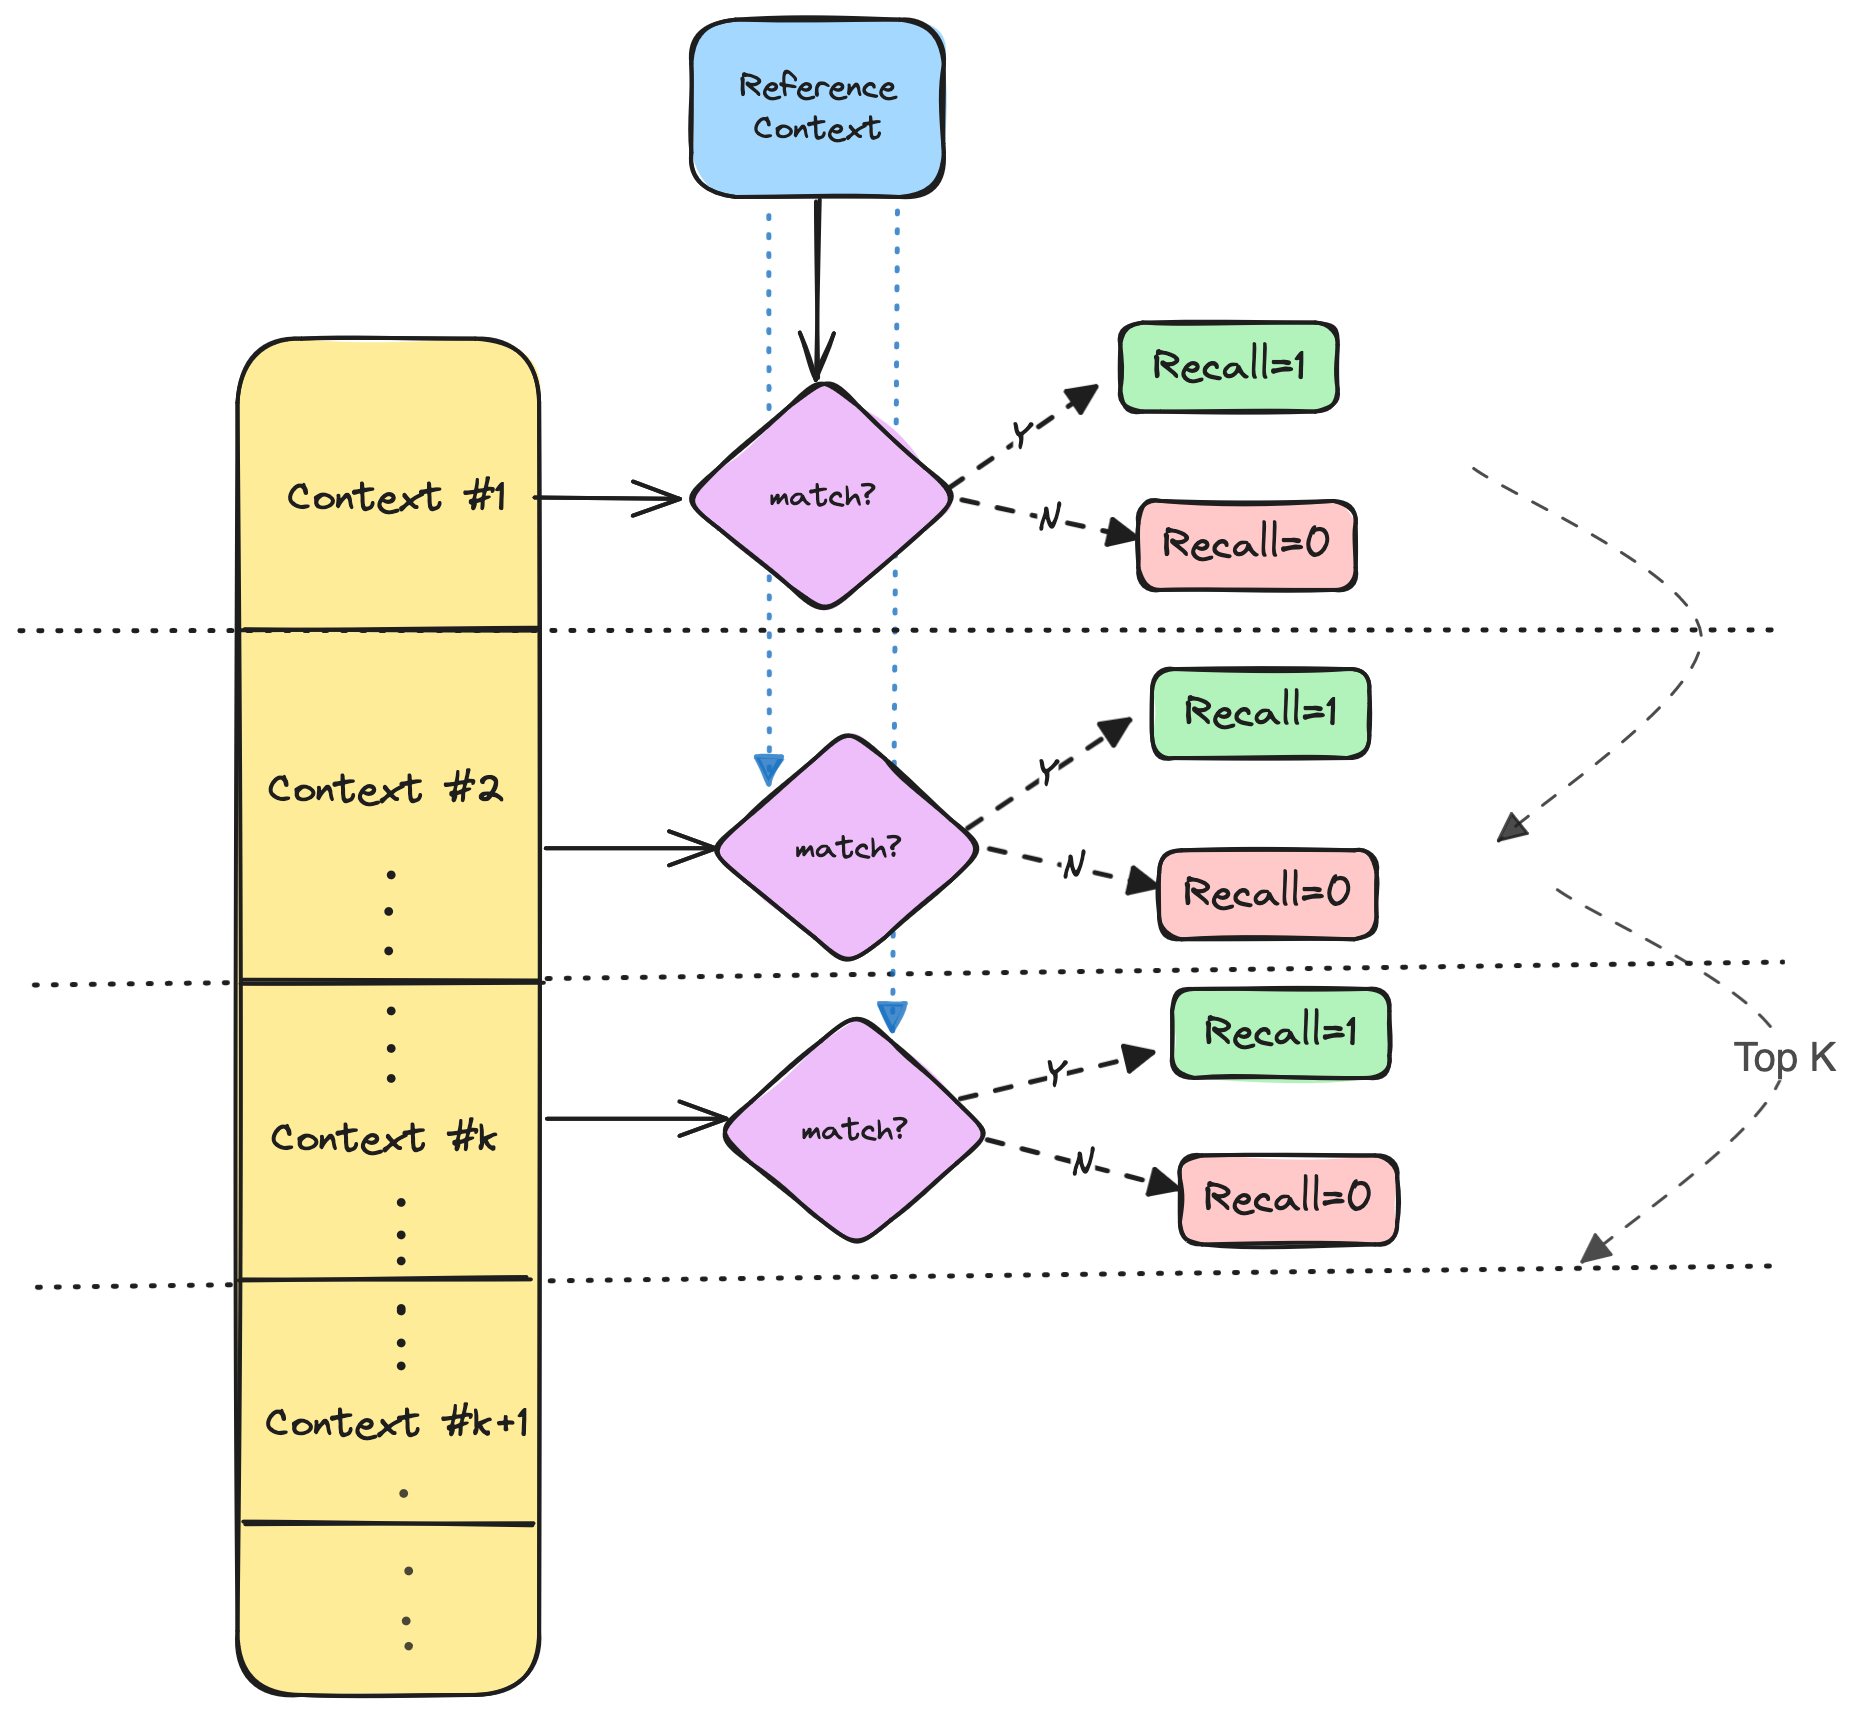

### Keyword-based evaluation

We compute the recall of retrieved contexts based on the overlapping of keywords between the
actual context (ground truth context) and the retrieved context.

In [44]:
def extract_keywords(text, top_k: int = 10):
    text = preprocess_text(text, top_k)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    keywords = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return set(keywords)

def preprocess_text(text, top_k=10):
    text = text.lower()
    r = Rake()
    r.extract_keywords_from_text(text)
    return " ".join(set(r.get_ranked_phrases()[:top_k]))

def compute_recall_kws(
    reference: str,
    retrieved_values: List[str],
    top_k: int = 1,
    top_k_kws: int = 10,
    threshold:float = 0.5,
    debug: bool = False,
) -> float:
    ref_keywords = extract_keywords(reference, top_k_kws)
    relevant_items = 0

    recall = 0.0

    if debug:
        print(f">>>>> reference = {reference}")
        print(f">>>>> reference keywords = {ref_keywords} | {len(ref_keywords)}")
    for idx, value in enumerate(retrieved_values, start=1):
        keywords = extract_keywords(value, top_k=top_k_kws)
        overlap = len(ref_keywords.intersection(keywords))
        score = overlap/len(ref_keywords)
        if debug:
            print(f">>>>> retrieved = {value}")
            print(f">>>>> retrieved kws = {keywords}")
            print(f">>>>> overlap = {overlap}")
            print(f">>>> score = {score}")

        if score >= threshold:
            recall = 1.0
        if idx >= top_k:
            break
    return recall

def evaluate_contexts_keywords(
    response: pd.DataFrame,
    threshold=0.5,
    top_k:int = 1,
    top_k_kws: int = 10,
    debug:bool=False
) -> pd.DataFrame:
    if "question" not in response and "prediction" not in response and "reference" not in response:
        response = simplify_response(response)

    response = response[response.retrieved_contexts.str.len() != 0]

    results = []
    for row in response.itertuples():
        context = row.context
        retrieved_contexts = row.retrieved_contexts
        retrieved_contexts = list(map(lambda x: x["page_content"], retrieved_contexts))
        recall = compute_recall_kws(
            context,
            retrieved_contexts,
            threshold=threshold,
            top_k=top_k,
            top_k_kws=top_k_kws,
            debug=debug
        )
        results.append(dict(
            context=context,
            question=row.question,
            answer=row.reference,
            prediction=row.prediction,
            retrieved_contexts=retrieved_contexts,
            recall=recall
        ))
    return pd.DataFrame(results)

In [131]:
def batch_evaluate_contexts_keywords(
    response: pd.DataFrame,
):
    final_df = []
    for threshold in [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        for top_k in range(1, 10):
            for top_k_kws in [25, 50]:
                result = evaluate_contexts_keywords(
                    response,
                    threshold=threshold,
                    top_k=top_k,
                    top_k_kws=top_k_kws,
                    debug=False
                )
                fname = f"data/evals/retrieval/keywords/eval-context-keywords-{threshold}-{top_k}-{top_k_kws}.csv"
                logger.debug(f"Dumping eval to {fname}")
                result.to_csv(fname, index=False)

def load_retrieval_eval_keywords(
    directory: str,
    pattern: Optional[str] = None
) -> pd.DataFrame:
    
    if pattern is None:
        pattern = "eval-context-keywords-([0-9.]+)-([0-9]+)-([0-9.]+).csv"
    
    dfs = []
    search_path = f"{directory}/eval-context-keywords*.csv"
    for path in glob.glob(search_path):
        df = pd.read_csv(path)
        match = re.search(pattern, path)
        if match:
            df["threshold"] = float(match.group(1))
            df["top_k"] = int(match.group(2))
            df["top_k_kws"] = int(match.group(3))
        dfs.append(df)
    df = pd.concat(dfs, axis=0)
    df["retrieved_contexts"] = df["retrieved_contexts"].apply(ast.literal_eval)
    return df

In [237]:
def peek_evaluation_result(df: pd.DataFrame, peek_type:str ="max"):
    df = df.copy()
    peek_type = peek_type.lower().strip()
    if peek_type in ["max", "good"]:
        df = df[df['recall'] == df['recall'].max()]
    else:
        df = df[df['recall'] == df['recall'].min()]
        
    row = df.sample(n=1).iloc[0]

    header_tag = "h4"
    display(HTML(f"<h3>{'Good' if peek_type in ['max', 'good'] else 'Bad'} Recall (Passage Overlap Threshold={row['threshold']}, top_k={row['top_k']})</h3"))
    display(HTML(f"<{header_tag}>Question</{header_tag}>"))
    print(row["question"])

    display(HTML(f"<{header_tag}>Generated Answer</{header_tag}>"))
    print(row["prediction"])

    display(HTML(f"<{header_tag}>Actual Answer</{header_tag}>"))
    print(row["answer"])

    display(HTML(f"<{header_tag}>Actual Context</{header_tag}>"))
    print(row["context"])

    display(HTML("<hr/>"))
    for idx, ctx in enumerate(row["retrieved_contexts"], start=1):
        display(HTML(f"<{header_tag}>Retrieved Context #{idx}</{header_tag}>"))
        print(ctx)

In [240]:
def plot_mean_recall_kws(df, figsize=(12, 6)):
    df = df.copy()
    df['top_k'] = pd.to_numeric(df['top_k'], errors='coerce')
    df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')
    df['recall'] = pd.to_numeric(df['recall'], errors='coerce')
    df['top_k_kws'] = pd.to_numeric(df['top_k_kws'], errors='coerce')

    # df = df.groupby(['threshold', 'top_k', 'top_k_kws'])['recall'].mean().reset_index()

    # df_mean_recall = df.copy()

    # mean recall vs. top_k with lines for each threshold
    plt.figure(figsize=figsize)
    ax = sns.lineplot(data=df, x='top_k', y='recall', hue='threshold', marker='o', palette='hls')
    plt.title('Recall by Top K Retrieved Contexts (colored by Passage Overlap Threshold)')
    plt.xlabel('Top K')
    plt.ylabel('Recall')
    plt.legend(title='Passage Overlap Threshold')

    lines, labels = ax.get_legend_handles_labels()
    for line, label in zip(ax.lines, labels[:]):  # Skip the first label as it is the legend title
        x, y = line.get_data()
        plt.text(x[-1], y[-1], f' {label}', verticalalignment='center')  # Annotate the end of the line
    
    plt.show()

In [194]:
eval_retrieval_kws = load_retrieval_eval_keywords(directory="data/evals/retrieval/keywords/")
print(eval_retrieval_kws.shape)
eval_retrieval_kws.head()

(30996, 9)


,context,question,answer,prediction,retrieved_contexts,recall,threshold,top_k,top_k_kws
0,Genome-wide transcriptional profiling showed t...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...,The gene expression alterations in Drosophila ...,[26-Jun-2013 notifications share GeneLab ID ...,1.0,0.25,6,25
1,Genome-wide transcriptional profiling showed t...,What kind of experiments showed differential r...,simulation experiments on ground testing space...,Experiments involving reducing gravity levels ...,[26-Jun-2013 notifications share GeneLab ID ...,1.0,0.25,6,25
2,Genome-wide transcriptional profiling showed t...,What is overrepresented in the different exper...,the same GO groups including a large multigene...,"The same GO groups, including a large multigen...","[Curiously, although <b>particular</b> <b>gene...",1.0,0.25,6,25
3,Genome-wide transcriptional profiling showed t...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...,The findings suggest that the transcriptome is...,"[These results suggest that, in addition to be...",1.0,0.25,6,25
4,The objective of the Rodent Research-5 (RR-5) ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...,The main goal of the Rodent Research-5 (RR-5) ...,[12-Aug-2019 notifications share GeneLab ID ...,1.0,0.25,6,25


In [198]:
eval_retrieval_kws.describe()

,recall,threshold,top_k,top_k_kws
count,30996.000000,30996.000000,30996.000000,30996.000000
mean,0.359595,0.375000,5.000000,37.500000
std,0.479889,0.085393,2.582031,12.500202
min,0.000000,0.250000,1.000000,25.000000
25%,0.000000,0.300000,3.000000,25.000000
50%,0.000000,0.375000,5.000000,37.500000
75%,1.000000,0.450000,7.000000,50.000000
max,1.000000,0.500000,9.000000,50.000000


In [201]:
peek_evaluation_result(eval_retrieval_kws, peek_type="good")

What is a key component of the overall response of cells to radiation?


A key component of the overall response of cells to radiation is the radiation bystander response.


The radiation bystander response


The radiation bystander response is an important component of the overall response of cells to radiation and critical to understanding health risks of radiation exposure to humans. The mechanism of radiation response includes inter-cellular signaling and intra-cellular communication by which the bystander signal is propagated. Methods: We measured the bystander response to 1Gy a-particle radiation in Mrad9-/- mouse stem cells and H1299shRAD9 cells, using chromosomal aberration and micronucleus formation as DNA damage endpoints. In the H1299 model we used whole genome microarray analyses to profile the transcriptome of irradiated and bystander cells. Results: We investigated the role of RAD9 in the bystander response and showed that depletion or mutation of RAD9 had an effect of increasing chromosomal structural damage as well as micronucleus formation in bystander cells. The enhancement of the damage effect correlated strongly with a transcriptomic response in critical pathways. RAD9 d

The <b>radiation</b> bystander <b>response</b> is an important <b>component</b> of the <b>overall</b> <b>response</b> of <b>cells</b> to <b>radiation</b> and critical to understanding health risks of <b>radiation</b> exposure to humans. The mechanism of <b>radiation</b> <b>response</b> includes inter-cellular signaling and intra-cellular communication by which the bystander signal is propagated. Methods: We measured the bystander <b>response</b> to 1Gy a-particle <b>radiation</b> in Mrad9-/- mouse stem <b>cells</b> and H1299shRAD9 <b>cells</b>, using chromosomal aberration and micronucleus formation as DNA damage endpoints. In the H1299 model we used whole genome microarray analyses to profile the transcriptome of irradiated and bystander <b>cells</b>. Results:


The <b>radiation</b> bystander effect is an important <b>component</b> of the <b>overall</b> biological <b>response</b> of tissues and organisms to ionizing <b>radiation</b>. Little is known about the contribution of genome level changes in neighboring bystander <b>cells</b> to tissue and organ stress after irradiation. The timing of these changes is critical in the physiological context and these questions can only be answered by studying signaling and global transcriptomics in a chronological way. Here, we present a strategy to identify different biologically important signaling modules that act in concert in the <b>radiation</b> and bystander <b>responses</b>.


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  471.12 MB  OSD-183 Version 1  <b>Radiation</b>-induced bystander effects and gene expression in <b>cells</b> deficient for RAD9 Study  Initial Release Date: 7-Oct-2014  notifications share  GeneLab ID : GLDS-183 DOI : 10.26030/dw0w-hr28 Source Accession : E-GEOD-55869  Cite this Study  info Description  Description  Background: The <b>radiation</b> bystander <b>response</b> is an important <b>component</b> of the <b>overall</b> <b>response</b> of <b>cells</b> to <b>radiation</b> and critical to understanding health risks of <b>radiation</b> exposure to humans.


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  1.34 GB  OSD-178 Version 1  IMR90 <b>radiation</b> bystander time-course experiment 0.5Gy alpha particle Study  Submitted Date: 05-May-2010  Initial Release Date: 14-Jan-2011  notifications share  GeneLab ID : GLDS-178 DOI : 10.26030/ksgn-e439 Source Accession : E-GEOD-21059  Cite this Study  info Description  Description  The <b>radiation</b> bystander effect is an important <b>component</b> of the <b>overall</b> biological <b>response</b> of tissues and organisms to ionizing <b>radiation</b>.


Radiation affects tissue and cellular integrity at the level of DNA, protein and metabolites of the cell and extracellular space. The effects of radiation are not limited to targeted cells and tissue and radiation induced bystander effects are significant to exposed individuals in accidental or therapeutic situations. These non-targeted effects of radiation have been studied extensively at the low dose range where they appear to have adverse effects on cells and surrounding environments.


The brain's response to radiation exposure is an important concern for patients undergoing cancer therapy and astronauts on long missions in deep space. We assessed whether this response is specific and prolonged and is linked to epigenetic mechanisms. We focused on the response of the hippocampus at early (2-weeks) and late (20-week) time points following whole body proton irradiation.


MicroRNAs miR-579, 608, 548-3p, and 585 are noted for targeting genes involved in radioresponsive mechanisms, such as <b>cell</b> cycle checkpoint and apoptosis. We suggest here a model in which miRNAs may act as hub regulators of specific cellular <b>responses</b>, immediately down-regulated so as to stimulate DNA repair mechanisms, followed by up-regulation involved in suppressing apoptosis for <b>cell</b> survival. Taken together, miRNAs may mediate signaling pathways in sequential fashion in <b>response</b> to <b>radiation</b>, and may serve as biodosimetric markers of <b>radiation</b> exposure. <b>Overall</b> design:


The existence of a radiation bystander effect, in which non-irradiated cells respond to signals from irradiated cells, is well established. It raises concerns for the interpretation of risks from exposure to low doses of ionizing radiation. Sparse data exists about the bystander signaling mechanisms and the ability to transmit damaging effects both spatially and temporally. To understand early signaling and cellular changes in bystanders, we have measured global gene expression 30 minutes after direct and bystander exposure to alpha particle in primary human lung fibroblasts.


Plants exhibit a robust transcriptional <b>response</b> to gamma <b>radiation</b> which includes the induction of transcripts required for homologous recombination and the suppression of transcripts that promote <b>cell</b> cycle progression. Various DNA damaging agents induce different spectra of DNA damage as well as 'collateral' damage to other cellular <b>components</b> and therefore are not expected to provoke identical <b>responses</b> by the <b>cell.</b> Here we study the effects of two different types of ionizing <b>radiation</b> (IR) treatment, HZE (1 GeV Fe26+ high mass, high charge, and high energy relativistic particles) and gamma photons, on the transcriptome of Arabidopsis thaliana seedlings.


Plants exhibit a robust transcriptional <b>response</b> to gamma <b>radiation</b> which includes the induction of transcripts required for homologous recombination and the suppression of transcripts that promote <b>cell</b> cycle progression. Various DNA damaging agents induce different spectra of DNA damage as well as collateral damage to other cellular <b>components</b> and therefore are not expected to provoke identical <b>responses</b> by the <b>cell.</b> Here we study the effects of two different types of ionizing <b>radiation</b> (IR) treatment, HZE (1 GeV Fe26+ high mass, high charge, and high energy relativistic particles) and gamma photons, on the transcriptome of Arabidopsis thaliana seedlings.


In [197]:
peek_evaluation_result(eval_retrieval_kws, peek_type="bad")

What hardware was used to grow the plant samples 


The plant samples were grown using different hardware depending on the specific experiment. Some of the hardware mentioned in the context includes the Vegetable Production System (VPS/Veggie), Petri Dish Fixation Units (PDFUs) within Biological Research In Canisters (BRIC), and Petri dishes within the BRIC-PDFU spaceflight hardware.


Vegetable Production System (VPS/Veggie)


When germinated and grown on-board the ISS (International Space Station), plant do not exhibit abnormal structures but they do have altered growth habits and this project aims to investigate the molecular mechanisms that provide the foundation for the altered growth habits observed in orbit. APEX03-2 (Advanced Plant Experiment 03-2), also known as TAGES-ISA (Transgenic Arabidopsis Gene Expression System-Intracellular Signaling Architecture) specifically addresses the growth and molecular changes that occur in Arabidopsis thaliana plants during spaceflight by using molecular and genetic tools, and by asking fundamental questions regarding root structure, growth and cell wall remodeling may be answered. This investigation advances the fundamental understanding of the molecular biological responses to extraterrestrial environments. This understanding helps to further define the impacts of spaceflight on biological systems to better enable NASA's future space exploration goals.


The plates were <b>grown</b> in the Vegetable Production System (VPS/Veggie) <b>hardware</b> on the Columbus Module of the ISS with the overhead LED lighting of the VPS. At four or for the second experimental set at eight days, seedlings were harvested by an astronaut into KFT (Kennedy Fixation Tube) containing RNAlater solutions. Upon return to Earth, the harvested material was <b>used</b> to compare the transcriptomes of each genotype and each age <b>using</b> RNAseq technology.


Yet, most investigations of <b>plant</b> adaptation to the spaceflight environment have been carried out on the dicotyledonous model <b>plant</b>, Arabidopsis thaliana. It remains unknown whether the conclusions from such studies can be extrapolated to monocotyledonous <b>plants</b>. To fill this knowledge gap, seedlings of three different accessions of Brachypodium distachyon (Bd21, Bd21-3, and Gaz8), a model for temperate grasses including cereal crops, were <b>grown</b> on the International Space Station in the Veggie <b>hardware</b> and on the ground in matched conditions. To synchronize germination, seedlings were <b>grown</b> for 24 hours in red light.


BMSC were <b>grown</b> in porous bioceramic Skelite disks (dia 9 mm x T 1.2 mm). The constructs were exposed to microgravity for ca. 8 days, then fixed for RNA extraction. While the flight experiment was performed in fully automated <b>hardware</b> inside the KUBIK incubator, one group of control <b>samples</b> were incubated inside manually operated <b>hardwares</b> (flight control), and the other control group was incubated under routine laboratory conditions (lab control). The altered gene expression profile was analyzed by Mouse Gene 1.0 ST array (Affymetrix) representing whole-transcript coverage.


Isa (Transgenic Arabidopsis Gene Expression System—Intracellular Signaling Architecture) was launched on SpaceX mission CRS-5 on 10 January 2015. Dry, sterilized Arabidopsis seeds were <b>planted</b> aseptically on the surface of 10-cm2 solid media plates and remained dormant until removed from cold stowage and exposed to light at the initiation of the experiment on the ISS (International Space Station). The plates were <b>grown</b> in the Vegetable Production System (VPS/Veggie) <b>hardware</b> on the Columbus Module of the ISS with the overhead LED lighting of the VPS.


The cultured cell lines were <b>grown</b> within 60mm Petri plates in Petri Dish Fixation Units (PDFUs) that were housed within the Biological Research In Canisters (BRIC) <b>hardware</b>. Spaceflight <b>samples</b> were fixed on orbit. Differentially expressed genes were identified between the two environments (spaceflight and comparable ground controls) and the two genotypes (WT and ARG1 KO). Each genotype engaged unique genes during physiological adaptation to the spaceflight environment, with little overlap.


Arabidopsis thaliana was evaluated for its response to the spaceflight environment in three replicated experiments on the International Space Station. Two approaches were <b>used</b>; GFP reporter genes were <b>used</b> to collect gene expression data in real time within unique GFP imaging <b>hardware</b>, and <b>plants</b> were harvested on orbit to RNAlater for subsequent analyses of gene expression with <b>using</b> Affymetrix and SAGE transcriptome analyses. Three tissue types were examined (leaves, hypocotyls and roots) and compared to analyses conducted with whole <b>plants</b>.


This study examined tissue-specific early transcriptional responses upon reorientation in wild type and starchless pgm-1 mutant seedlings of Arabidopsis. Seedlings were <b>grown</b> in vertical Petri dishes for four days. Treatment <b>samples</b> were reoriented 90 degrees for ten minutes while control <b>plants</b> remained vertical. All seedlings were flash frozen in liquid nitrogen and RNA was extracted from root tips, mature root, hypocotyl, and cotyledon fractions of the seedlings. RNA was sequenced via NovaSeq.  Factor(s)  Factor  Ontology: Concept  Genotype  Genotype  Organism Part  Organism Part  Treatment  treatment  Organism(s)  Arabidopsis thaliana  Assay(s)  Measurement  Technology  Device Platform  transcription profiling


info Description  Description  The BRIC-21 mission was designed to identify the response of Bacillus subtilis to the human spaceflight environment. For this mission, <b>samples</b> were <b>grown</b> in rich-medium <b>using</b> the Biological Research in Canister Petri Dish Fixation Units (BRIC-PDFU) spaceflight <b>hardware</b>. B. subtilis spores were inoculated during spaceflight, grown at the ambient ISS temperature, and frozen in the onboard -80 C freezer prior to returning to Earth. RNA was extracted from <b>samples</b> grown onboard the International Space Station (ISS) and matching Ground Controls for transcriptome analysis.  Factor(s)  Factor  Ontology: Concept  Spaceflight  Space Flight  Organism(s)


from the <b>plants</b> at weekly intervals. Ground controls were <b>grown</b> simultaneously with a 24-72 h delay <b>using</b> ISS environmental data. Food safety of the <b>plants</b> was determined by heterotrophic plate counts for bacteria and fungi, as well as isolate identification <b>using</b> <b>samples</b> taken from the leaves and roots. Molecular characterization was conducted <b>using</b> Next Generation Sequencing (NGS) to provide taxonomic composition and phylogenetic structure of the community.


In [57]:
eval_retrieval_kws.describe()

,recall,threshold,top_k,top_k_kws
count,30996.000000,30996.000000,30996.000000,30996.000000
mean,0.359595,0.375000,5.000000,37.500000
std,0.479889,0.085393,2.582031,12.500202
min,0.000000,0.250000,1.000000,25.000000
25%,0.000000,0.300000,3.000000,25.000000
50%,0.000000,0.375000,5.000000,37.500000
75%,1.000000,0.450000,7.000000,50.000000
max,1.000000,0.500000,9.000000,50.000000


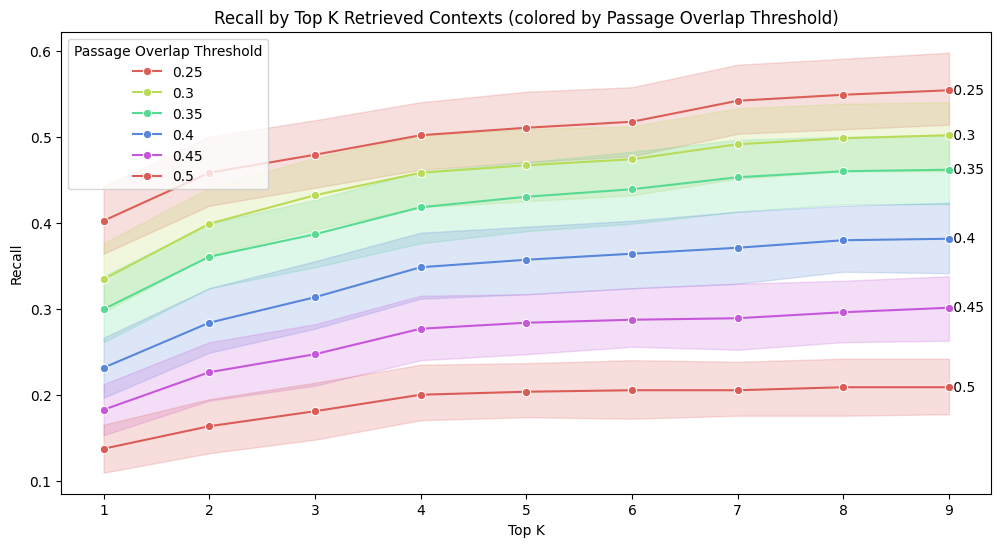

In [241]:
plot_mean_recall_kws(eval_retrieval_kws)

### Semantic Retrieval Evaluation

In [101]:
BERT_SCORE = BertScore(per_instance_score=True)

In [102]:
def compute_recall_semantic(
    reference: str,
    retrieved_values: List[str],
    top_k: int = 1,
    top_k_kws: int = 10,
    threshold:float = 0.5,
    debug: bool = False,
) -> float:
    
    recall = 0.0

    retrieved_values = retrieved_values[:top_k]
    references = [reference] * len(retrieved_values)
    predictions = retrieved_values.copy()
    result = BERT_SCORE(references=references, predictions=predictions)
    max_score = max(result.extra["bertscore"]["recall"])
    
    return float(max_score >= threshold), max_score

def evaluate_contexts_semantic(
    response: pd.DataFrame,
    threshold=0.5,
    top_k:int = 1,
    top_k_kws: int = 10,
    debug:bool=False
) -> pd.DataFrame:
    if "question" not in response and "prediction" not in response and "reference" not in response:
        response = simplify_response(response)

    response = response[response.retrieved_contexts.str.len() != 0]

    results = []
    for row in response.itertuples():
        context = row.context
        retrieved_contexts = row.retrieved_contexts
        retrieved_contexts = list(map(lambda x: x["page_content"], retrieved_contexts))
        recall, score = compute_recall_semantic(
            context,
            retrieved_contexts,
            threshold=threshold,
            top_k=top_k,
            top_k_kws=top_k_kws,
            debug=debug
        )
        if debug:
            print(recall, score)
        results.append(dict(
            context=context,
            question=row.question,
            answer=row.reference,
            prediction=row.prediction,
            retrieved_contexts=retrieved_contexts,
            recall=recall,
            score=score,
        ))
    return pd.DataFrame(results)

In [185]:
def batch_eval_semantic_v2(response):
    thresholds = [0.5, 0.65]
    top_k_vals = [1, 5, 10]
    for threshold in thresholds:
        for top_k in top_k_vals:
            logger.debug(f"Evaluating for threshold={threshold}, top_k={top_k}")
            result = evaluate_contexts_semantic_v2(
                response,
                threshold=threshold,
                top_k=top_k, 
                top_k_kws=50,
                debug=False)
            fname = f"data/eval-context-bertscore-{threshold}-{top_k}.csv"
            logger.debug(f"Dumping eval to {fname}")
            result.to_csv(fname, index=False)

def load_context_eval_semantic() -> pd.DataFrame:
    dfs = []
    pattern = "eval-context-bertscore-([0-9.]+)-([0-9]+).csv"
    for path in glob.glob("data/evals/retrieval/bertscore/eval-context-bertscore*.csv"):
        df = pd.read_csv(path)
        match = re.search(pattern, path)
        if match:
            df["threshold"] = float(match.group(1))
            df["top_k"] = int(match.group(2))
        dfs.append(df)
    df = pd.concat(dfs, axis=0)
    df["retrieved_contexts"] = df["retrieved_contexts"].apply(ast.literal_eval)
    return df

In [242]:
def plot_mean_recall_semantic(df, figsize=(12, 6)):
    df = df.copy()
    df['top_k'] = pd.to_numeric(df['top_k'], errors='coerce')
    df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')
    df['recall'] = pd.to_numeric(df['recall'], errors='coerce')

    # recall vs. top_k with lines for each threshold
    plt.figure(figsize=figsize)
    ax = sns.lineplot(data=df, x='top_k', y='recall', hue='threshold', marker='o', palette='dark')
    plt.title('Recall by Top K Retrieved Contexts (colored by Passage Overlap Threshold)')
    plt.xlabel('Top K')
    plt.ylabel('Recall')
    plt.legend(title='Passage Overlap Threshold')

    lines, labels = ax.get_legend_handles_labels()
    for line, label in zip(ax.lines, labels[:]):  # Skip the first label as it is the legend title
        x, y = line.get_data()
        plt.text(x[-1], y[-1], f' {label}', verticalalignment='center')  # Annotate the end of the line
    
    plt.show()

    # recall vs. threshold with lines for each top_k_kws
    plt.figure(figsize=figsize)
    sns.lineplot(data=df, x='threshold', y='recall', marker='o', palette='vlag')
    plt.title('Recall by Passage Overlap Threshold')
    plt.xlabel('Passage Overlap Threshold')
    plt.ylabel('Recall')
    plt.show()

In [188]:
eval_retrieval_semantic = load_context_eval_semantic()
eval_retrieval_semantic.head()

,context,question,answer,prediction,retrieved_contexts,recall,score,threshold,top_k
0,Genome-wide transcriptional profiling showed t...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...,The gene expression alterations in Drosophila ...,[26-Jun-2013 notifications share GeneLab ID ...,1.0,0.709230,0.5,10
1,Genome-wide transcriptional profiling showed t...,What kind of experiments showed differential r...,simulation experiments on ground testing space...,Experiments involving reducing gravity levels ...,[26-Jun-2013 notifications share GeneLab ID ...,1.0,0.701952,0.5,10
2,Genome-wide transcriptional profiling showed t...,What is overrepresented in the different exper...,the same GO groups including a large multigene...,"The same GO groups, including a large multigen...","[Curiously, although <b>particular</b> <b>gene...",1.0,0.706340,0.5,10
3,Genome-wide transcriptional profiling showed t...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...,The findings suggest that the transcriptome is...,"[These results suggest that, in addition to be...",1.0,0.722527,0.5,10
4,The objective of the Rodent Research-5 (RR-5) ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...,The main goal of the Rodent Research-5 (RR-5) ...,[12-Aug-2019 notifications share GeneLab ID ...,1.0,0.587473,0.5,10


In [189]:
eval_retrieval_semantic.describe()

,recall,score,threshold,top_k
count,3444.000000,3444.000000,3444.000000,3444.000000
mean,0.527294,0.581817,0.575000,5.333333
std,0.499327,0.107731,0.075011,3.682322
min,0.000000,0.357976,0.500000,1.000000
25%,0.000000,0.490861,0.500000,1.000000
50%,1.000000,0.572280,0.575000,5.000000
75%,1.000000,0.675793,0.650000,10.000000
max,1.000000,0.936264,0.650000,10.000000


In [233]:
peek_evaluation_result(eval_retrieval_semantic, peek_type="good")

What was the procedure followed for the mice from the RR-23 mission after their oceanic landing and subsequent transportation?


After the oceanic landing, the mice from the RR-23 mission were transported to the Kennedy Space Center via helicopter. They were then removed from Rodent Transporters (Flight and HGC) or vivarium cages (VGC), placed into shipping containers, and flown to Texas A and M University. At the university, the mice underwent post-flight procedures before being euthanized and having their tissues collected. The animals were euthanized and dissected on January 14th, 17th, or 20th of 2021, depending on their group (Flight, HGC, or VGC).


The mice, after landing in the Atlantic, were transported by helicopter to the Kennedy Space Center, where post-flight procedures were conducted.


The objective of the Rodent Research-23 missions (RR-23) was to better understand the effects of spaceflight on the eyes, specifically on the structure and function of the arteries, veins, and lymphatic vessels that are needed to maintain vision. To this end, twenty male, C57BL/6J, 16-17 weeks-old mice were delivered to the ISS on SpaceX-21 in a single transporter, transferred to two rodent habitats, and maintained in microgravity for 38 days. Flight mice were then returned to Earth alive (Jan 13th, 2021). After splashdown in the Atlantic Ocean, mice were transported to Kennedy Space Center via helicopter. The 20 Flight, 20 Habitat Ground Control (HGC), and 20 Vivarium Ground Control (VGC) mice were removed from Rodent Transporters (Flight and HGC) or vivarium cages (VGC), placed into shipping containers, and flown to Texas A and M University. There, mice underwent post-flight procedures, before euthanasia and tissue collection. Flight, HGC and VGC animals were euthanized and dissected

Flight <b>mice</b> were then returned to Earth alive (January 13th, 2021). <b>After</b> splashdown in the Atlantic Ocean, <b>mice</b> were transported to Kennedy Space Center via helicopter. The 20 Flight, 20 Habitat Ground Control (HGC), and 20 Vivarium Ground Control (VGC) <b>mice</b> were removed <b>from</b> Rodent Transporters (Flight and HGC) or vivarium cages (VGC), placed into shipping containers, and flown to Texas A and M University. There, <b>mice</b> underwent post-flight <b>procedures</b>, before euthanasia and tissue collection. Flight, HGC and VGC animals were euthanized and dissected on Jan 14th, 17th or 20th of 2021, respectively.


The 20 Flight, 20 Habitat Ground Control (HGC), and 20 Vivarium Ground Control (VGC) <b>mice</b> were removed <b>from</b> Rodent Transporters (Flight and HGC) or vivarium cages (VGC), placed into shipping containers, and flown to Texas A and M University. There, <b>mice</b> underwent post flight <b>procedures</b>, before euthanasia and tissue collection. Flight, HGC and VGC animals were euthanized and dissected on Jan 14th, 17th or 20th of 2021, respectively.


There, <b>mice</b> underwent post flight <b>procedures</b>, before euthanasia and tissue collection. Flight, HGC and VGC animals were euthanized and dissected on Jan 14th, 17th or 20th of 2021, respectively. Kidneys were preserved by immersion in RNAlater and stored at -80 ̊C until RNA was extracted, and libraries generated and sequenced (target 60 M clusters per sample, PE 150 bp). This dataset features 9 samples <b>from</b> the Flight group, 9 samples <b>from</b> the HGC group, and 9 samples <b>from</b> the VGC group. A technical replicate is included for one sample in each group.


There, <b>mice</b> underwent post flight <b>procedures</b>, before euthanasia and tissue collection. Flight, HGC and VGC animals were euthanized and dissected on Jan 14th, 17th or 20th of 2021, respectively. Cerebellums were preserved by immersion in RNAlater and stored at -80 ̊C until RNA was extracted, and libraries generated and sequenced (target 60 M clusters per sample, PE 150 bp). This dataset features 9 samples <b>from</b> the Flight group, 9 samples <b>from</b> the HGC group, and 8 samples <b>from</b> the VGC group. A technical replicate is included for one sample in each group.


The 20 Flight, 20 Habitat Ground Control (HGC), and 20 Vivarium Ground Control (VGC) <b>mice</b> were removed <b>from</b> Rodent Transporters (Flight and HGC) or vivarium cages (VGC), placed into shipping containers, and flown to Texas A and M University. There, <b>mice</b> underwent post-flight <b>procedures</b>, before euthanasia and tissue collection. Flight, HGC and VGC animals were euthanized and dissected on Jan 14th, 17th or 20th of 2021, respectively.


In [235]:
peek_evaluation_result(eval_retrieval_semantic, peek_type="bad")

What leads to marked bone loss in animal models?


Reduced skeletal loading leads to marked bone loss in animal models.


Reduced skeletal loading


Reduced skeletal loading leads to marked bone loss. Animal models of hindlimb suspension are widely used to assess alterations in skeleton during the course of complete unloading. More recently, the effects of partial unloading on the musculoskeletal system have been interrogated in mice and rats, revealing dose-dependent effects of partial weight bearing (PWB) on the skeleton and skeletal muscle. Here, we extended these studies to determine the structural and functional skeletal alterations in 14-week-old male Wister rats exposed to 20%, 40%, 70%, or 100% of body weight for 1, 2, or 4 weeks (n equals 11–12/group). Using in vivo pQCT, we found that trabecular bone density at the proximal tibia declined in proportion to the degree of unloading and continued progressively with time, without evidence of a plateau by 4 weeks. Ex vivo measurements of trabecular microarchitecture in the distal femur by microcomputed tomography revealed deficits in bone volume fraction, 2 and 4 weeks after un

10.26030/emsm-0648 Related Study : OSD-418  Cite this Study  info Description  Description  Reduced skeletal loading <b>leads</b> to <b>marked</b> <b>bone</b> <b>loss</b>. <b>Animal</b> <b>models</b> of hindlimb suspension are widely used to assess alterations in skeleton during the course of complete unloading. More recently, the effects of partial unloading on the musculoskeletal system have been interrogated in mice and rats, revealing dose-dependent effects of partial weight bearing (PWB) on the skeleton and skeletal muscle.


10.26030/b09t-mw60 Related Studies : OSD-418 , OSD-608  Cite this Study  info Description  Description  Reduced skeletal loading <b>leads</b> to <b>marked</b> <b>bone</b> <b>loss</b>. <b>Animal</b> <b>models</b> of hindlimb suspension are widely used to assess alterations in skeleton during the course of complete unloading. More recently, the effects of partial unloading on the musculoskeletal system have been interrogated in mice and rats, revealing dose-dependent effects of partial weight bearing (PWB) on the skeleton and skeletal muscle.


Microgravity produces a variety of physical, chemical, and biological cues <b>leading</b> to an intricate and largely unresolved network of mechanosensitive molecules, transduction pathways, oxidative stress-related responses, and adaptations. The <b>bone</b> <b>loss</b> observed in astronauts and <b>animal</b> <b>models</b> after spaceflight is attributable to alterations in the <b>bone</b> tissue formation that depends on the continuous remodelling through the activities of <b>bone</b>-resorbing osteoclasts of hematopoietic lineage and <b>bone</b>-forming osteoblast of mesenchymal origin.


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  318.33 KB  OSD-608 Version 1  Dose-dependent skeletal deficits due to varied reductions in mechanical loading in rats (Tibia - pQCT) Study  Submitted Date: 25-Apr-2023  Initial Release Date: 17-May-2023  notifications share  ALSDA ID : LSDS-41 DOI : 10.26030/emsm-0648 Related Study : OSD-418  Cite this Study  info Description  Description  Reduced skeletal loading <b>leads</b> to <b>marked</b> <b>bone</b> <b>loss</b>.


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  863.11 KB  OSD-477 Version 1  Dose-dependent skeletal deficits due to varied reductions in mechanical loading in rats (Femur - microCT, three-point bending, histomorphometry) Study  Submitted Date: 20-Apr-2023  Initial Release Date: 22-May-2023  notifications share  ALSDA ID : LSDS-40 DOI : 10.26030/b09t-mw60 Related Studies : OSD-418 , OSD-608  Cite this Study  info Description  Description  Reduced skeletal loading <b>leads</b> to <b>marked</b> <b>bone</b> <b>loss</b>.


Spaceflight-induced vertebral <b>bone</b> <b>loss</b> in ovariectomized rats is associated with increased <b>bone</b> marrow adiposity and no change in <b>bone</b> formation  Authors : Keune Jessica A, Philbrick Kenneth A, Branscum Adam J, Iwaniec Urszula T, Turner Russell T  DOI : 10.1038/npjmgrav.2016.16  sim_card_download Files  Study Files Selected: 0  Search Files  search  OSD-310  Study Metadata Files  Histomorphometry  view_timeline Version History  Selected Version  Version 1  Updated Date: 27-Mar-2023  Changes: New data release  Files Added (3)  OSD-310_metadata_OSD-310-ISA.zip  LSDS-30_histomorphometry_LV_NASA_4_19_18.xlsx  LSDS-30_histomorphometry_turnerTRANSFORMED.xlsx  Show/Hide All Version Information  FOLLOW US  @NASAGeneLab  NASA GeneLab  NASA-GeneLab  CONTACTS


info Description  Description  Bone growth may occur in spaceflight as a response to skeletal unloading and head-ward fluid shifts. While unloading causes significant loss of bone mass and density in legs of animals exposed to microgravity, increased blood and interstitial fluid flows accompanying microgravity-induced fluid redistribution may elicit an opposite effect in the head. Seven 23-week-old, adult female wild-type C57BL/6 mice were randomly chosen for exposure to 15 days of microgravity on the STS-131 mission, while eight female littermates served as ground controls.


Spaceflight resulted in lower cortical bone accrual in the femur but had no effect on cortical bone in the humerus or calvarium. Cancellous bone volume fraction was lower in flight animals compared to ground control animals in lumbar vertebra and distal femur metaphysis and epiphysis; significant differences were not detected in the distal humerus. Bone loss (compared to baseline controls) in the femur metaphysis was associated with lower trabecular number, whereas trabecular thickness and number were lower in the epiphysis. This dataset is only for the ovariectomized animals.


Prolonged skeletal unloading through bedrest results in bone loss similar to that observed in elderly osteoporotic patients, but with an accelerated timeframe. This rapid effect on weight-bearing bones is also observed in astronauts who lose up to 2% of their bone mass per month spent in Space. Despite important implications for Spaceflight travellers and bedridden patients on Earth, the exact mechanisms involved in disuse osteoporosis have not been elucidated. Parathyroid hormone-related protein (PTHrP) regulates many physiological processes including skeletal development, and has been proposed as a gravisensor.


info Description  Description  Adverse effects of spaceflight on musculoskeletal health increase the risk of <b>bone</b> injury and impairment of fracture healing. Its yet elusive molecular comprehension warrants immediate attention, since space travel is becoming more frequent. Here we examined the effects of spaceflight on <b>bone</b> fracture healing using a 2 mm femoral segmental <b>bone</b> defect (SBD) <b>model</b>. Forty, 9-week-old, male C57BL/6J mice were randomized into 4 groups:


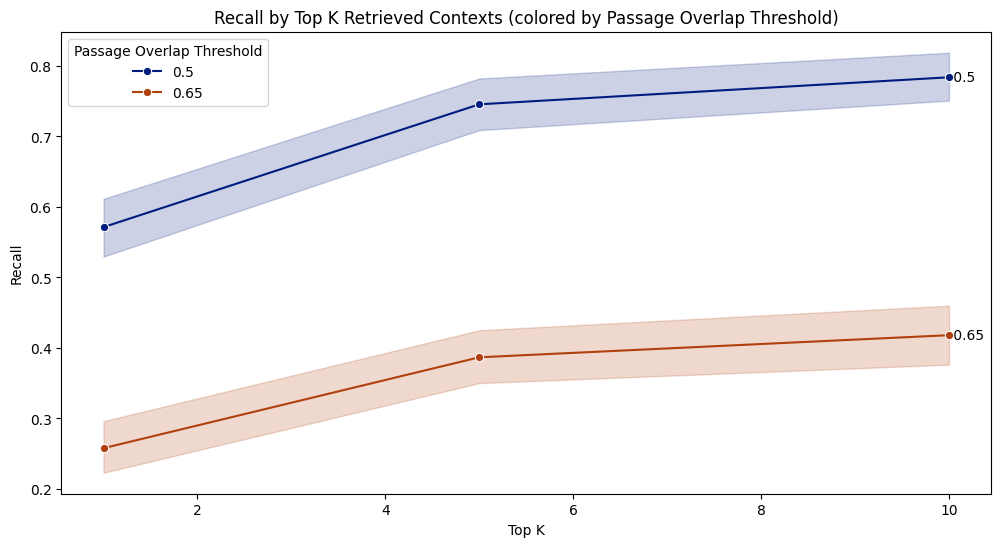

/var/folders/_y/xn9wmmrx1_s68jvjw4gzmxfm0000gn/T/ipykernel_45817/4215088815.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x='threshold', y='recall', marker='o', palette='vlag')


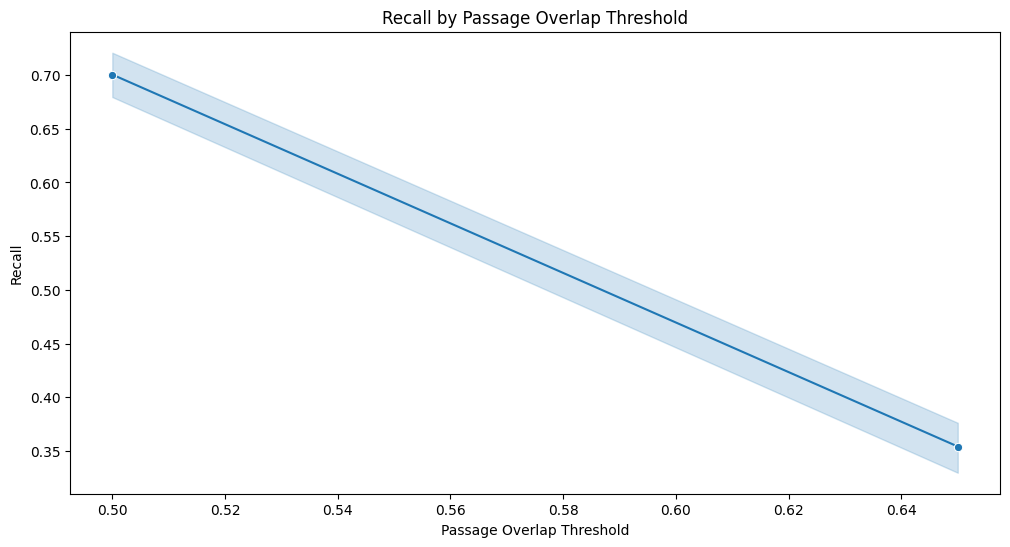

In [243]:
plot_mean_recall_semantic(eval_retrieval_semantic)

## QA Evaluation

Here we focus on semantic evaluation of generated answers which suggest the correctness of the answer w.r.t reference answer.

We use following metrics:


1. **Exacth Match**
2. **METEOR** (Metric for Evaluation of Translation with Explicit Ordering)
    - more aligned with human judgment
    - accounts for exact word matches, *synonyms*, and *paraphrases*
    - useful for evaluating correctness across varied wordings
3. **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation)
   - focuses on recall, measuring *word overlaps* with reference
   - indicates content overlap rather than linguistic quality
   - lower score may suggest fewer exact word matches
4. **BERT Score**
    - *semantic* similarity using contextual embeddings
    - measures how well the generated answers match with references in meaning
    - generalized comparison for a variety of downstream tasks (QA, Translation, Summarization, etc.)

In [255]:
def evaluate_qa(response: pd.DataFrame) -> pd.DataFrame:
    if "question" not in response and "prediction" not in response and "reference" not in response:
        response = simplify_response(response)
    evaluator = Evaluator(metrics=[
        BertScore(),
        ExactMatchMetric(),
        MeteorMetric(),
        RougeMetric(),
    ])
    results = evaluator(
        references=response["reference"].to_list(),
        predictions=response["prediction"].to_list()
    )
    results = pd.DataFrame(results)
    return results

In [256]:
def simplify_response(response: pd.DataFrame) -> pd.DataFrame:
    response = response.copy()
    response["result"] = response["result"].apply(ast.literal_eval)
    res = []
    for row in response.itertuples():
        res.append(dict(
            context=row.reference_context,
            context_hash=row.context_hash,
            question=row.question,
            reference=row.reference_answer,
            ground_truth=row.reference_answer,
            prediction=row.result["answer"],
            retrieved_contexts=row.result["source_documents"]
        ))
    return pd.DataFrame(res)

In [257]:
def plot_eval_result(df: pd.DataFrame):
    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(x='metric_name', y='score', data=df, palette='husl')
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.3f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')
    plt.title('Comparison of Metrics')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    plt.show()

In [258]:
eval_qa = evaluate_qa(
    # response=simplify_response(pd.read_csv("data/responses-gpt-3.5-turbo.csv"))
    response=pd.read_csv("data/responses-simplified-gpt-3.5-turbo-rephrased.csv")
)

/Users/npantha/dev/impact/experiments/osdr-bot/venv/lib/python3.10/site-packages/jury/metrics/_core/auto.py:106: UserWarning: Metric exact_match is not available on jury, falling back to evaluate metric. You may not fully utilize this metric for different input types, e.g multiple predictions or multiple references.
  warnings.warn(


In [263]:
eval_qa

,score,total_items,metric_name,empty_items,extra
0,0.665739,295,BertScore,0,"{'bertscore': {'score': 0.6657390467191147, 'p..."
1,0.037288,295,ExactMatchMetric,0,"{'exact_match': 0.03728813559322034, 'flattene..."
2,0.510066,295,MeteorMetric,0,{'meteor': {'score': 0.5100657697400938}}
3,0.372583,295,RougeMetric,0,"{'rouge': {'rouge1': 0.4218337644255253, 'roug..."


/var/folders/_y/xn9wmmrx1_s68jvjw4gzmxfm0000gn/T/ipykernel_45817/3910356460.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='metric_name', y='score', data=df, palette='husl')


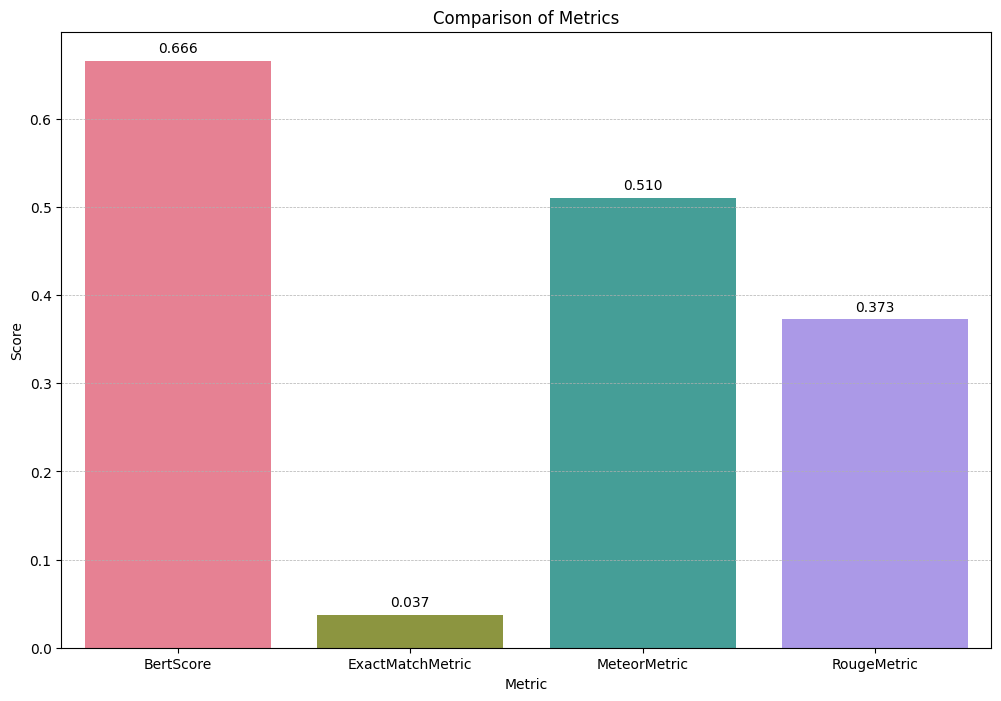

In [264]:
plot_eval_result(eval_qa)

# Footnotes
- [evalem](https://github.com/NASA-IMPACT/evalem)